In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import yaml

from tqdm.notebook import tqdm

import pickle


In [2]:
from spine.utils.tracking import get_track_segments
from spine.utils.mcs import mcs_angles


In [3]:
from spine.driver import Driver


In [4]:
cfg_txt = '''
base:
  verbosity: warning
io:
  reader:
    name: hdf5
    file_keys: DATA_PATH
    skip_unknown_attrs: true
    
# Build reconstruction output representations
build:
  mode: both
  units: cm
  fragments: false
  particles: true
  interactions: true
'''


In [5]:
# downloaded from /pnfs/sbnd/persistent/users/mueller/MCP2025B/full_hdf5_test_files/mc5e18/*.h5
#DATA_FILES = os.listdir('/nevis/riverside/data/leehagaman/spine/mc5e18')
DATA_FILES = os.listdir('/nevis/riverside/data/leehagaman/spine/highEmuon/h5s')

log_file_location = '/nevis/houston/home/leehagaman/spine/mcs_studies/logs'

for file in os.listdir(log_file_location):
    os.remove(f'{log_file_location}/{file}')

num_files = 500

print(f"loading {num_files} / {len(DATA_FILES)} files")

true_contained = []
reco_contained = []
true_primary = []
reco_primary = []
true_start_point = []
reco_start_point = []
true_start_dir = []
reco_start_dir = []
truth_ke = []
reco_ke = []
reco_mcs_ke = []
reco_csda_ke = []
reco_calo_ke = []

reco_segment_dirs = []
reco_segment_angles = []
true_segment_dirs = []
true_segment_angles = []

files = []

for file_i, DATA_FILE in tqdm(enumerate(DATA_FILES[:num_files]), total=num_files):

    #DATA_PATH = f'/nevis/riverside/data/leehagaman/spine/mc5e18/{DATA_FILE}'
    #DATA_PATH = f'/nevis/riverside/data/leehagaman/spine/sbnd_medium_spine.h5'
    DATA_PATH = f'/nevis/riverside/data/leehagaman/spine/highEmuon/h5s/{DATA_FILE}'

    disk_usage_MB = os.path.getsize(DATA_PATH) / (1024*1024)
    if disk_usage_MB < 0.1:
        print(f"skipping {DATA_FILE} because it is too small, {disk_usage_MB:.2f} MB")
        continue

    cfg = yaml.safe_load(cfg_txt.replace('DATA_PATH', DATA_PATH))
    driver = Driver(cfg)

    for ENTRY in range(len(driver)):
        data = driver.process(entry=ENTRY)

        for true_particle, reco_particle in data['particle_matches_t2r']:


            if abs(true_particle.pdg_code) != 13: # non-muon
                continue

            if not true_particle.is_matched: # no reco match
                continue

            reco_points = reco_particle.points
            true_points = true_particle.points

            curr_reco_segment_clusts, curr_reco_segment_dirs, curr_reco_segment_lengths = get_track_segments(reco_points, 14)
            curr_reco_segment_angles = mcs_angles(curr_reco_segment_dirs)
            reco_segment_dirs.append(curr_reco_segment_dirs)
            reco_segment_angles.append(curr_reco_segment_angles)

            curr_true_segment_clusts, curr_true_segment_dirs, curr_true_segment_lengths = get_track_segments(true_points, 14)
            curr_true_segment_angles = mcs_angles(curr_true_segment_dirs)
            true_segment_dirs.append(curr_true_segment_dirs)
            true_segment_angles.append(curr_true_segment_angles)
            
            true_contained.append(true_particle.is_contained)
            reco_contained.append(reco_particle.is_contained)
            
            true_primary.append(true_particle.is_primary)
            reco_primary.append(reco_particle.is_primary)

            true_start_point.append(true_particle.start_point)
            reco_start_point.append(reco_particle.start_point)

            true_start_dir.append(true_particle.start_dir)
            reco_start_dir.append(reco_particle.start_dir)

            truth_ke.append(true_particle.ke)
            reco_ke.append(reco_particle.ke)
            reco_mcs_ke.append(reco_particle.mcs_ke)
            reco_csda_ke.append(reco_particle.csda_ke)
            reco_calo_ke.append(reco_particle.calo_ke)

            files.append(DATA_FILE)


loading 500 / 987 files


  0%|          | 0/500 [00:00<?, ?it/s]

skipping larcv_mc_20250625_002907_453720_6485c990-b934-4bcb-91a3-d18fa55d9d78_spine.h5 because it is too small, 0.05 MB
skipping larcv_mc_20250625_002035_069472_17fbacd3-a17d-427c-b731-b1e731340fa8_spine.h5 because it is too small, 0.05 MB
skipping larcv_mc_20250625_003657_133030_176fc85b-94f0-4b23-963c-d8c22ffc91f3_spine.h5 because it is too small, 0.05 MB
skipping larcv_mc_20250625_003531_822579_2b4dba91-199d-41df-b6f7-108e7c4fd3d7_spine.h5 because it is too small, 0.05 MB
skipping larcv_mc_20250625_003319_101816_a483ec4e-abb6-4880-901d-f65364bce331_spine.h5 because it is too small, 0.05 MB
skipping larcv_mc_20250625_004049_103261_26bf3f1f-317a-4672-90ae-41441f25807f_spine.h5 because it is too small, 0.05 MB
skipping larcv_mc_20250625_004012_022047_6796e097-24d8-4c2c-8d0c-425d511d5b71_spine.h5 because it is too small, 0.05 MB
skipping larcv_mc_20250625_002927_123872_68e6dc43-2efd-4b46-8716-c0aafd5684b7_spine.h5 because it is too small, 0.05 MB
skipping larcv_mc_20250625_002027_148943

In [6]:
df = pd.DataFrame({
    'file': files,
    'true_contained': true_contained,
    'reco_contained': reco_contained,
    'true_primary': true_primary,
    'reco_primary': reco_primary,
    'true_start_point': true_start_point,
    'reco_start_point': reco_start_point,
    'true_start_dir': true_start_dir,
    'reco_start_dir': reco_start_dir,
    'truth_ke': truth_ke,
    'reco_ke': reco_ke,
    'reco_mcs_ke': reco_mcs_ke,
    'reco_csda_ke': reco_csda_ke,
    'reco_calo_ke': reco_calo_ke,
    'reco_segment_dirs': reco_segment_dirs,
    'reco_segment_angles': reco_segment_angles,
    'true_segment_dirs': true_segment_dirs,
    'true_segment_angles': true_segment_angles,
    })
df


,file,true_contained,reco_contained,true_primary,reco_primary,true_start_point,reco_start_point,true_start_dir,reco_start_dir,truth_ke,reco_ke,reco_mcs_ke,reco_csda_ke,reco_calo_ke,reco_segment_dirs,reco_segment_angles,true_segment_dirs,true_segment_angles
0,larcv_mc_20250625_003224_423586_6800396b-7173-...,False,False,True,True,"[30.149994, -111.75, 5.1499977]","[30.149994, -112.05, 5.450001]","[-0.15927163, 0.78837264, 0.59422314]","[-0.16810295, 0.80677176, 0.56644565]",99998.359695,1168.288896,1168.288896,902.203877,829.255615,"[[-0.19071268, 0.826427, 0.5297613], [-0.15151...","[0.07099739, 0.020732421, 0.05218969, 0.079851...","[[-0.19071268, 0.826427, 0.5297613], [-0.15151...","[0.07099739, 0.020732421, 0.05218969, 0.079851..."
1,larcv_mc_20250625_003224_423586_6800396b-7173-...,False,False,True,True,"[-161.65, 176.21774, 252.44998]","[-145.95001, 151.95001, 280.55002]","[0.391234, -0.59747154, 0.69997406]","[0.39829403, -0.5943896, 0.69861495]",100003.303772,99999.997218,99999.997218,736.306847,702.686401,"[[0.40702942, -0.57840943, 0.70694387], [0.407...","[7.97038e-07, 0.029936364, 0.029429799, 0.0293...","[[0.38402247, -0.59736854, 0.70404375], [0.385...","[0.060110416, 0.106258065, 0.036266964, 0.0638..."
2,larcv_mc_20250625_003224_423586_6800396b-7173-...,False,False,True,True,"[184.95001, 135.75, 336.65]","[184.95001, 135.75, 336.65002]","[-0.23169029, -0.32728773, -0.9160799]","[-0.22947192, -0.32301685, -0.9181518]",99998.404196,5895.426743,5895.426743,825.590635,780.842407,"[[0.23478901, 0.32016507, 0.9178063], [0.21386...","[0.07056688, 0.08997677, 0.0005644565, 0.09074...","[[0.23478901, 0.32016507, 0.9178063], [0.21386...","[0.07056688, 0.08997677, 0.06708555, 0.0521863..."
3,larcv_mc_20250625_003224_423586_6800396b-7173-...,False,False,True,True,"[-46.350006, 152.85, 266.74997]","[-46.350006, 153.45001, 266.75003]","[0.21591356, -0.9702141, -0.1098446]","[0.21547125, -0.9692011, -0.119253315]",99998.406552,1361.322301,1361.322301,828.109456,839.838745,"[[-0.23548526, 0.9633524, 0.1284483], [-0.2354...","[2.446163e-06, 0.06985905, 0.043946907, 0.0297...","[[-0.23548526, 0.9633524, 0.1284483], [-0.2354...","[2.446163e-06, 0.06985905, 0.043946907, 0.0297..."
4,larcv_mc_20250625_003224_423586_6800396b-7173-...,False,False,True,True,"[-59.850006, 36.75, 477.35]","[-59.850006, 37.049988, 477.05002]","[0.9264932, -0.28152186, -0.24971114]","[0.9209161, -0.29293114, -0.25710893]",99998.381833,1716.389589,1716.389589,641.247402,604.351013,"[[-0.9226938, 0.2726134, 0.2726134], [-0.93502...","[0.0448706, 0.029579625, 0.0132398205, 0.05181...","[[-0.9226938, 0.2726134, 0.2726134], [-0.93502...","[0.0448706, 0.029579625, 0.0132398205, 0.05181..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,larcv_mc_20250625_005342_173636_1e82d74a-e424-...,False,False,True,True,"[-163.05, 92.55002, 372.65]","[-163.05, 92.55002, 372.65002]","[0.44401732, -0.8560198, -0.26472372]","[0.44722262, -0.853316, -0.2680368]",100003.260975,991.915494,991.915494,784.177441,832.365723,"[[-0.44925493, 0.85572535, 0.25671804], [-0.44...","[0.020525206, 0.020342184, 0.07901565, 0.11412...","[[-0.44925493, 0.85572535, 0.25671804], [-0.44...","[0.020525206, 0.020342184, 0.07901565, 0.11412..."
2535,larcv_mc_20250625_005342_173636_1e82d74a-e424-...,False,False,True,True,"[-184.45001, -84.78224, 94.950005]","[-184.35, -84.75, 95.15]","[0.7189571, 0.6311895, 0.29103345]","[0.72078776, 0.6305699, 0.28783086]",99998.419277,1352.773186,1352.773186,1029.280834,1117.065186,"[[0.72603846, 0.61926806, 0.29895687], [0.7111...","[0.04230699, 0.020746492, 0.050813742, 0.06359...","[[0.72603846, 0.61926806, 0.29895687], [0.7111...","[0.04230699, 0.020746492, 0.050813742, 0.06359..."
2536,larcv_mc_20250625_005342_173636_1e82d74a-e424-...,False,False,True,True,"[-86.850006, 85.350006, 213.05002]","[-86.850006, 85.350006, 213.05002]","[0.705558, -0.707023, 0.04802431]","[0.69891304, -0.71361697, 0.047657922]",100003.238254,955.810361

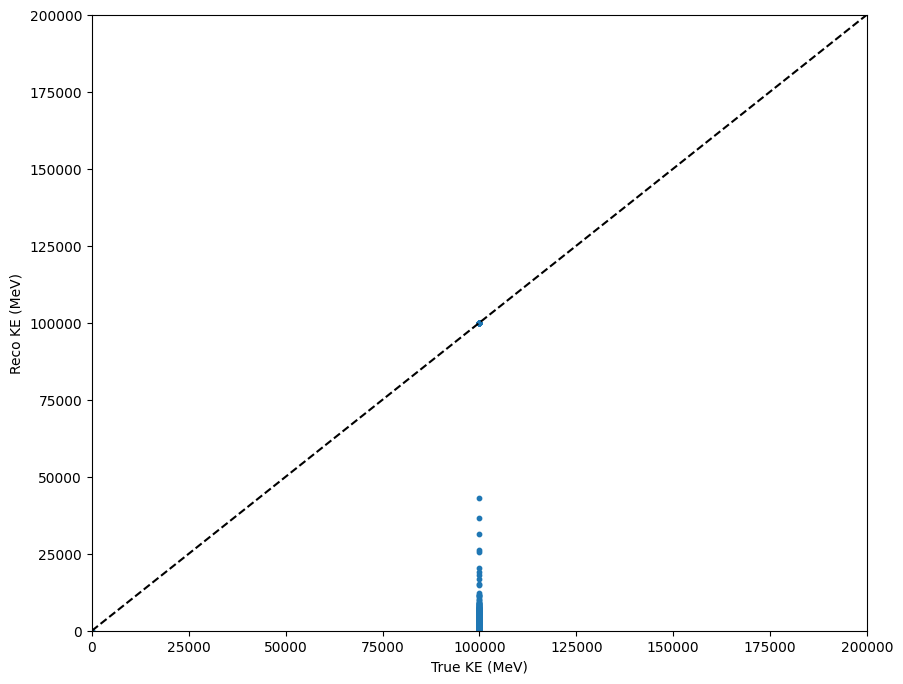

In [7]:
# plot reco energy vs true energy
plt.figure(figsize=(10, 8))
plt.scatter(df['truth_ke'], df['reco_ke'], s=10)
plt.plot([0, 200_000], [0, 200_000], 'k--')
plt.xlim(0, 200_000)
plt.ylim(0, 200_000)
plt.xlabel('True KE (MeV)')
plt.ylabel('Reco KE (MeV)')
plt.show()


In [8]:
with open('/nevis/houston/home/leehagaman/spine/mcs_studies/h5_highEmuon_with_segment_angles.pkl', 'wb') as f:
    pickle.dump(df, f)